=== STEP 1: Scanning sequence lengths in CAFA_Style dataset ===
Checking if CAFA_Style directory exists at: /teamspace/studios/this_studio/CAFA_Style/sequences
✓ CAFA_Style directory found
Searching for all seq.txt files in the dataset...


Finding seq.txt files: 0it [00:00, ?it/s]

✓ Found 59,397 seq.txt files under: /teamspace/studios/this_studio/CAFA_Style/sequences
Analyzing sequence lengths...


Scanning sequences:   0%|          | 0/59397 [00:00<?, ?it/s]


=== Sequence Length Summary ===
Files scanned        : 59,397
Non-empty sequences  : 59,397
Empty sequences      : 0
Min length (non-empty): 16
Max length (non-empty): 3,305
Range (max - min)     : 3,289
Mean length           : 523.43
Median length         : 421.00
Standard deviation    : 388.32

=== Percentile Analysis ===
 1th percentile: 74
 5th percentile: 124
10th percentile: 164
25th percentile: 266
50th percentile: 421
75th percentile: 653
90th percentile: 1,006
95th percentile: 1,300
99th percentile: 2,016

=== Length Distribution ===
        0-49 residues:    133 sequences (  0.2%)
       50-99 residues:  1,447 sequences (  2.4%)
     100-199 residues:  7,192 sequences ( 12.1%)
     200-299 residues:  8,976 sequences ( 15.1%)
     300-499 residues: 18,323 sequences ( 30.8%)
     500-749 residues: 11,877 sequences ( 20.0%)
     750-999 residues:  5,424 sequences (  9.1%)
   1000-1499 residues:  4,112 sequences (  6.9%)
   1500-1999 residues:  1,287 sequences (  2.2%)
   2000-2

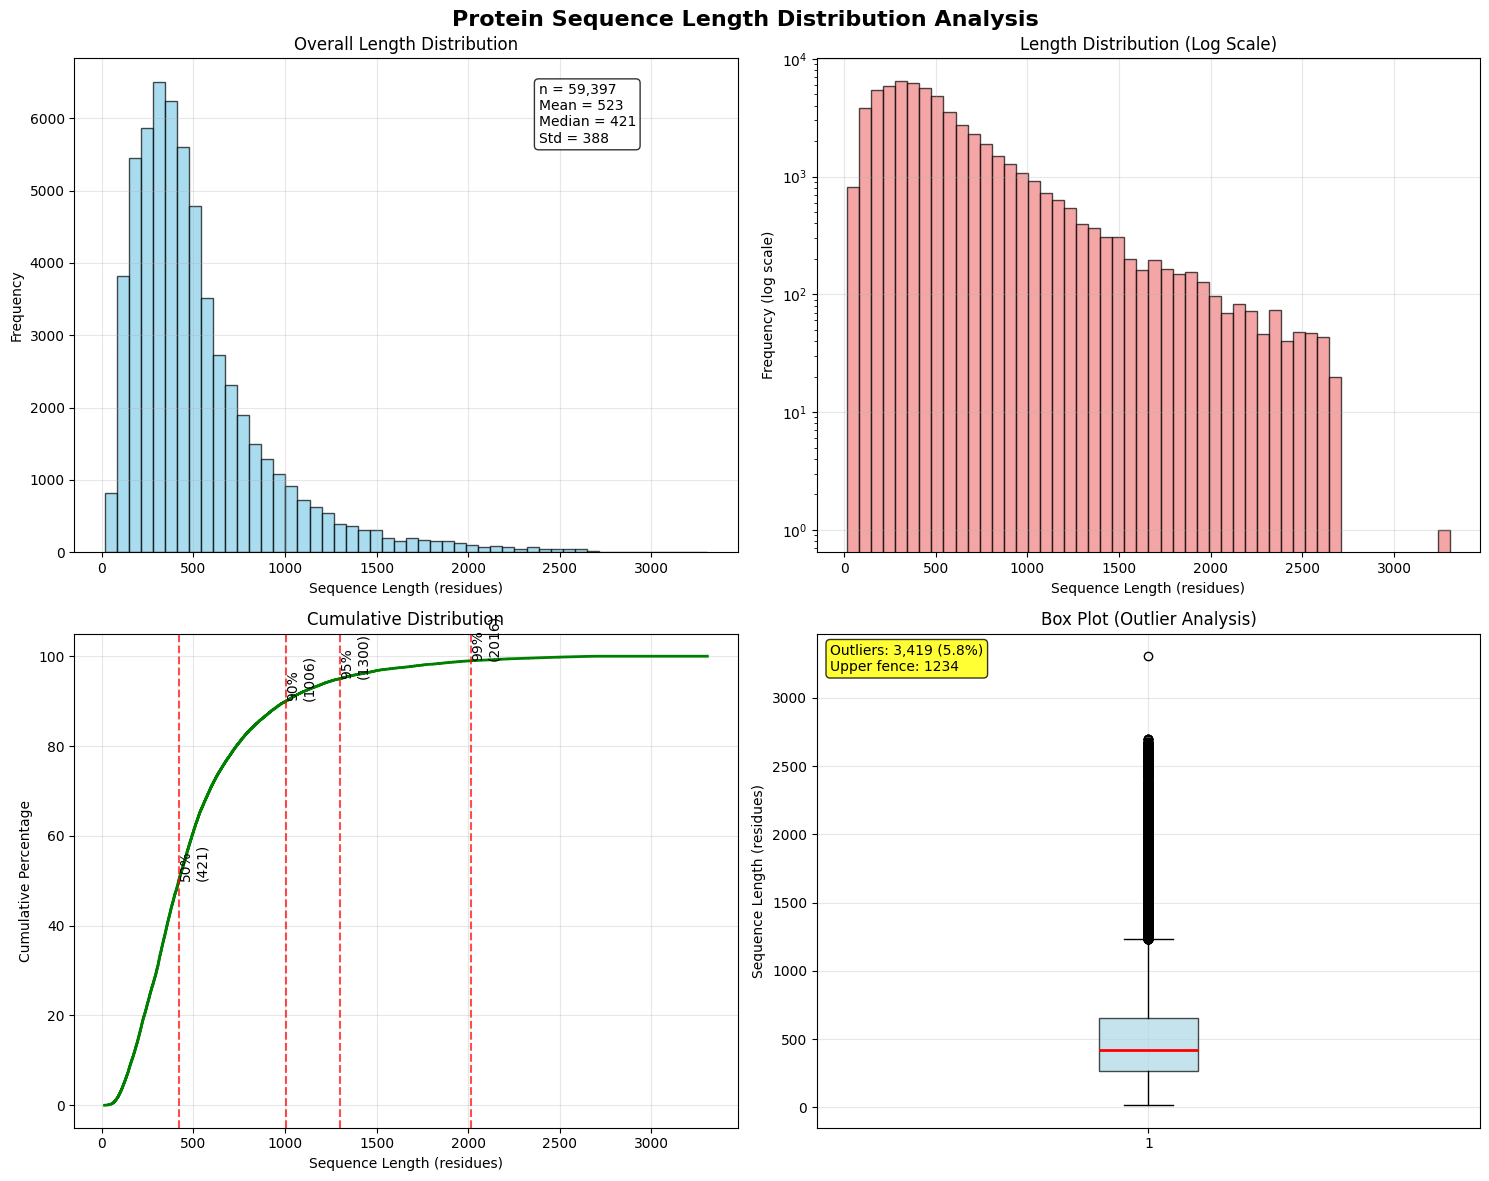

In [5]:
# JUPYTER CELL — Scan all seq.txt and report sequence-length range
from __future__ import annotations
from pathlib import Path
from tqdm.auto import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

print("=== STEP 1: Scanning sequence lengths in CAFA_Style dataset ===")

# Point to your CAFA_Style root
BASE = Path("/teamspace/studios/this_studio/CAFA_Style/sequences")

def read_seq_len(p: Path) -> int:
    """Read seq.txt → length of sequence with whitespace removed (0 if file missing/empty)."""
    try:
        txt = p.read_text(encoding="utf-8")
    except FileNotFoundError:
        return 0
    return len("".join(txt.split()))

print(f"Checking if CAFA_Style directory exists at: {BASE}")
if not BASE.exists():
    raise FileNotFoundError(f"CAFA_Style not found at: {BASE}")

print("✓ CAFA_Style directory found")

# Find every seq.txt anywhere under CAFA_Style
print("Searching for all seq.txt files in the dataset...")
seq_paths = []
for seq_file in tqdm(BASE.rglob("seq.txt"), desc="Finding seq.txt files"):
    seq_paths.append(seq_file)
print(f"✓ Found {len(seq_paths):,} seq.txt files under: {BASE}")

print("Analyzing sequence lengths...")
lengths = []
non_empty_lengths = []
n_empty = 0

for p in tqdm(seq_paths, desc="Scanning sequences"):
    L = read_seq_len(p)
    lengths.append(L)
    if L == 0:
        n_empty += 1
    else:
        non_empty_lengths.append(L)

n_total = len(lengths)
n_non_empty = len(non_empty_lengths)

print("\n=== Sequence Length Summary ===")
print(f"Files scanned        : {n_total:,}")
print(f"Non-empty sequences  : {n_non_empty:,}")
print(f"Empty sequences      : {n_empty:,}")

if n_non_empty == 0:
    print("⚠️  No non-empty sequences found; min/max/range are N/A.")
else:
    min_len = min(non_empty_lengths)
    max_len = max(non_empty_lengths)
    rng_len = max_len - min_len
    avg_len = sum(non_empty_lengths) / n_non_empty
    median_len = np.median(non_empty_lengths)
    std_len = np.std(non_empty_lengths)

    print(f"Min length (non-empty): {min_len:,}")
    print(f"Max length (non-empty): {max_len:,}")
    print(f"Range (max - min)     : {rng_len:,}")
    print(f"Mean length           : {avg_len:,.2f}")
    print(f"Median length         : {median_len:,.2f}")
    print(f"Standard deviation    : {std_len:,.2f}")
    
    # Percentile analysis
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    print("\n=== Percentile Analysis ===")
    for p in percentiles:
        val = np.percentile(non_empty_lengths, p)
        print(f"{p:2d}th percentile: {val:,.0f}")
    
    # Length distribution bins
    print("\n=== Length Distribution ===")
    bins = [0, 50, 100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, float('inf')]
    bin_labels = ['0-49', '50-99', '100-199', '200-299', '300-499', '500-749', 
                  '750-999', '1000-1499', '1500-1999', '2000-2999', '3000+']
    
    bin_counts = [0] * len(bin_labels)
    for length in non_empty_lengths:
        for i, (low, high) in enumerate(zip(bins[:-1], bins[1:])):
            if low <= length < high:
                bin_counts[i] += 1
                break
    
    for label, count in zip(bin_labels, bin_counts):
        pct = (count / n_non_empty) * 100
        print(f"{label:>12} residues: {count:>6,} sequences ({pct:5.1f}%)")
    
    # Identify very long sequences (>2048, which is common model limit)
    very_long = [l for l in non_empty_lengths if l > 2048]
    if very_long:
        print(f"\n⚠️  Found {len(very_long):,} sequences longer than 2048 residues")
        print(f"   Longest sequence: {max(very_long):,} residues")
        print(f"   These may need truncation for some models")
    
    # Create visualization
    print("\n=== Creating Length Distribution Plots ===")
    
    # Set up the figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Protein Sequence Length Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Histogram with reasonable binning
    ax1.hist(non_empty_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Sequence Length (residues)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Overall Length Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = f'n = {n_non_empty:,}\nMean = {avg_len:.0f}\nMedian = {median_len:.0f}\nStd = {std_len:.0f}'
    ax1.text(0.7, 0.95, stats_text, transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Log-scale histogram for better visualization of tail
    ax2.hist(non_empty_lengths, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.set_xlabel('Sequence Length (residues)')
    ax2.set_ylabel('Frequency (log scale)')
    ax2.set_yscale('log')
    ax2.set_title('Length Distribution (Log Scale)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative distribution
    sorted_lengths = np.sort(non_empty_lengths)
    cumulative_pct = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
    ax3.plot(sorted_lengths, cumulative_pct, color='green', linewidth=2)
    ax3.set_xlabel('Sequence Length (residues)')
    ax3.set_ylabel('Cumulative Percentage')
    ax3.set_title('Cumulative Distribution')
    ax3.grid(True, alpha=0.3)
    
    # Add key percentile lines
    for p in [50, 90, 95, 99]:
        val = np.percentile(non_empty_lengths, p)
        ax3.axvline(val, color='red', linestyle='--', alpha=0.7)
        ax3.text(val, p, f'{p}%\n({val:.0f})', rotation=90, verticalalignment='bottom')
    
    # 4. Box plot with outlier analysis
    ax4.boxplot(non_empty_lengths, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    ax4.set_ylabel('Sequence Length (residues)')
    ax4.set_title('Box Plot (Outlier Analysis)')
    ax4.grid(True, alpha=0.3)
    
    # Add outlier statistics
    Q1 = np.percentile(non_empty_lengths, 25)
    Q3 = np.percentile(non_empty_lengths, 75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    outliers = [l for l in non_empty_lengths if l < lower_fence or l > upper_fence]
    
    outlier_text = f'Outliers: {len(outliers):,} ({len(outliers)/n_non_empty*100:.1f}%)\nUpper fence: {upper_fence:.0f}'
    ax4.text(0.02, 0.98, outlier_text, transform=ax4.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    


In [1]:
"""
Generate ESM-C (600M) sequence embeddings for PIDs that appear under the
CAFA_Style <split>/mf/* directories, *reading sequences from*
CAFA_Style/sequences/<PID>/seq.txt and *writing*
CAFA_Style/sequences/<PID>/esmc_emb.pt.

This preserves the original embedding logic (ESM-C -> (1, L+2, 1152) with
[CLS]/[EOS] already handled by the model) and only changes how we enumerate
PIDs, and where we read/write.

Layout expected:
    /teamspace/studios/this_studio/CAFA_Style/
      ├─ train/mf/<PID>/
      ├─ val/mf/<PID>/
      ├─ test/mf/<PID>/
      └─ sequences/<PID>/seq.txt   # created by your flat builder

Output per PID:
    sequences/<PID>/esmc_emb.pt     # torch.Tensor, shape (1, L+2, 1152)

Run:
    python embed_esmc_cafa_style.py

Notes:
- Skips PIDs whose embeddings already exist.
- Skips PIDs with missing/empty sequences, with a warning.
- Uses GPU if available.
"""
from __future__ import annotations

import os
from pathlib import Path
from typing import Iterable, Set

import torch
from tqdm.auto import tqdm

# ─────────────────────────────── config ─────────────────────────────── #
BASE          = Path("/teamspace/studios/this_studio/CAFA_Style")
ONTOLOGY      = "mf"                       # only embed PIDs that appear under this ontology
SPLITS        = ["train", "val", "test"]
SEQS_DIR      = BASE / "sequences"        # source of seq.txt and target for esmc_emb.pt
OUT_FILENAME  = "esmc_emb.pt"             # what downstream expects
MODEL_NAME    = "esmc_600m"               # Fair-ESM registry tag
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ────────────────────────────────────────────────────────────────────── #


def gather_pids_from_mf(base: Path, splits: Iterable[str]) -> Set[str]:
    """Union of subfolder names under <base>/<split>/mf/* for all splits.
    If a split folder is missing, it is ignored (but a message is shown).
    """
    pids: Set[str] = set()
    for split in splits:
        root = base / split / ONTOLOGY
        if not root.exists():
            tqdm.write(f"[WARN] Missing folder: {root} — skipping this split")
            continue
        for item in root.iterdir():
            if item.is_dir():
                pids.add(item.name)
    return pids


def read_sequence(seqs_dir: Path, pid: str) -> str:
    seq_path = seqs_dir / pid / "seq.txt"
    if not seq_path.exists():
        return ""
    # Accept either FASTA-like or plain; strip headers/whitespace
    with seq_path.open("r", encoding="utf-8") as fh:
        seq = []
        for line in fh:
            if line.startswith(">"):
                continue
            seq.append(line.strip())
    return ("".join(seq)).upper()


@torch.inference_mode()
def embed_sequence(model, seq: str) -> torch.Tensor:
    """Run ESM-C and return a CPU tensor shaped (1, L+2, 1152).

    `model.encode` already prepends CLS & appends EOS.
    """
    from esm.sdk.api import ESMProtein, LogitsConfig

    prot   = ESMProtein(sequence=seq)
    hidden = model.encode(prot)  # (1, L+2, 1152) on DEVICE
    out    = model.logits(hidden, LogitsConfig(sequence=True, return_embeddings=True))
    return out.embeddings.cpu()  # move straight to CPU to save VRAM


def main() -> None:
    if not BASE.exists():
        raise FileNotFoundError(f"CAFA_Style base not found: {BASE}")
    SEQS_DIR.mkdir(parents=True, exist_ok=True)

    pids = sorted(gather_pids_from_mf(BASE, SPLITS))
    if not pids:
        print("No PIDs found under <split>/mf — nothing to do.")
        return

    print(f"Found {len(pids)} unique PIDs under mf across {SPLITS}\n")

    print(f"⇢ Loading {MODEL_NAME} onto {DEVICE} …")
    from esm.models.esmc import ESMC

    model = ESMC.from_pretrained(MODEL_NAME).to(DEVICE).eval()

    made, skipped_exist, skipped_empty = 0, 0, 0
    for pid in tqdm(pids, desc="Embedding (ESM-C)"):
        out_path = SEQS_DIR / pid / OUT_FILENAME
        if out_path.exists():
            skipped_exist += 1
            continue

        seq = read_sequence(SEQS_DIR, pid)
        if not seq:
            tqdm.write(f"[WARN] {pid}: missing/empty seq.txt in sequences — skipping")
            skipped_empty += 1
            continue

        emb = embed_sequence(model, seq)  # (1, L+2, 1152)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(emb, out_path)
        made += 1
        tqdm.write(f"✓ {pid}: L={len(seq):4d} → {OUT_FILENAME}")

    print(
        f"\nDone. created={made} | existing_skipped={skipped_exist} | missing_seq_skipped={skipped_empty}"
    )


if __name__ == "__main__":
    main()


Found 32546 unique PIDs under mf across ['train', 'val', 'test']

⇢ Loading esmc_600m onto cuda …


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/esm/pretrained.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


Embedding (ESM-C):   0%|          | 0/32546 [00:00<?, ?it/s]

✓ 128UP_DROME: L= 368 → esmc_emb.pt
✓ 14310_ARATH: L= 254 → esmc_emb.pt
✓ 14311_ARATH: L= 252 → esmc_emb.pt
✓ 14333_ARATH: L= 255 → esmc_emb.pt
✓ 14335_ARATH: L= 268 → esmc_emb.pt
✓ 1433B_HUMAN: L= 246 → esmc_emb.pt
✓ 1433B_MOUSE: L= 246 → esmc_emb.pt
✓ 1433B_RAT: L= 246 → esmc_emb.pt
✓ 1433E_DROME: L= 262 → esmc_emb.pt
✓ 1433E_HUMAN: L= 255 → esmc_emb.pt
✓ 1433E_MOUSE: L= 255 → esmc_emb.pt
✓ 1433E_RAT: L= 255 → esmc_emb.pt
✓ 1433F_HUMAN: L= 246 → esmc_emb.pt
✓ 1433F_MOUSE: L= 246 → esmc_emb.pt
✓ 1433G_HUMAN: L= 247 → esmc_emb.pt
✓ 1433G_MOUSE: L= 247 → esmc_emb.pt
✓ 1433G_RAT: L= 247 → esmc_emb.pt
✓ 1433S_HUMAN: L= 248 → esmc_emb.pt
✓ 1433S_MOUSE: L= 248 → esmc_emb.pt
✓ 1433T_HUMAN: L= 245 → esmc_emb.pt
✓ 1433T_MOUSE: L= 245 → esmc_emb.pt
✓ 1433T_RAT: L= 245 → esmc_emb.pt
✓ 1433Z_HUMAN: L= 245 → esmc_emb.pt
✓ 1433Z_MOUSE: L= 245 → esmc_emb.pt
✓ 1433Z_RAT: L= 245 → esmc_emb.pt
✓ 1433_DICDI: L= 252 → esmc_emb.pt
✓ 1A111_ARATH: L= 460 → esmc_emb.pt
✓ 1A12_ARATH: L= 496 → esmc_emb.pt
✓ 1A

In [ ]:
"""
Generate ProtT5 (XL-UniRef50) sequence embeddings for PIDs that appear under
CAFA_Style <split>/mf/*, reading sequences from
CAFA_Style/sequences/<PID>/seq.txt and writing the embeddings to
CAFA_Style/sequences/<PID>/prot_t5_emb.pt.

Output per PID:
    sequences/<PID>/prot_t5_emb.pt   # torch.Tensor, shape (1, L+2, 1024)
                                     # CLS/EOS slots are zero-filled

Notes
-----
- We *only* embed PIDs that exist under <split>/mf (splits: train/val/test).
- Tokenization follows the official ProtT5 recipe: space-separated residues.
- Ambiguous residues U,Z,O,B are mapped to 'X' (per official ProtT5 preprocessing); otherwise sequences are passed as-is to the tokenizer.
- Existing files are skipped silently; progress bar shows overall progress.
- Preserves original embedding logic; only I/O and PID enumeration changed.
"""
from __future__ import annotations

from pathlib import Path
from typing import Iterable, Set

import re
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, T5EncoderModel

# ─────────────────────────────── config ─────────────────────────────── #
BASE          = Path("/teamspace/studios/this_studio/CAFA_Style")
ONTOLOGY      = "mf"                       # only embed PIDs that appear under this ontology
SPLITS        = ["train", "val", "test"]
SEQS_DIR      = BASE / "sequences"        # source of seq.txt and target for embeddings
OUT_FILENAME  = "prot_t5_emb.pt"          # (1, L+2, 1024) with zero CLS/EOS rows
MODEL_NAME    = "Rostlab/prot_t5_xl_uniref50"
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE         = torch.float32
# ────────────────────────────────────────────────────────────────────── #



def gather_pids_from_mf(base: Path, splits: Iterable[str]) -> Set[str]:
    """Union of subfolder names under <base>/<split>/mf/* for all splits.
    Missing split folders are ignored with a warning.
    """
    pids: Set[str] = set()
    for split in splits:
        root = base / split / ONTOLOGY
        if not root.exists():
            tqdm.write(f"[WARN] Missing folder: {root} — skipping this split")
            continue
        for item in root.iterdir():
            if item.is_dir():
                pids.add(item.name)
    return pids


def read_sequence(seqs_dir: Path, pid: str) -> str:
    seq_path = seqs_dir / pid / "seq.txt"
    if not seq_path.exists():
        return ""
    seq_parts = []
    with seq_path.open("r", encoding="utf-8") as fh:
        for line in fh:
            if line.startswith(">"):
                continue
            seq_parts.append(line.strip())
    # Build raw sequence (uppercase), then map ambiguous residues per official ProtT5 recipe
    seq = ("".join(seq_parts)).upper()
    seq = re.sub(r"[UZOB]", "X", seq)
    if not seq:
        return ""
    return seq


@torch.inference_mode()
def embed_prott5(model: T5EncoderModel, tok: AutoTokenizer, seq: str) -> torch.Tensor:
    """Return ProtT5 embeddings as (1, L+2, 1024) with zero CLS/EOS rows.

    - Tokenize with space-separated residues and add special tokens.
    - Take encoder last_hidden_state [T, 1024], drop EOS to keep [L, 1024].
    - Place into a zero-initialized (1, L+2, 1024) with positions 1..L filled.
    """
    spaced = " ".join(seq)
    enc = tok(spaced, return_tensors="pt", add_special_tokens=True)
    enc = {k: v.to(DEVICE) for k, v in enc.items()}

    out = model(**enc).last_hidden_state[0].to(DTYPE)  # [T, 1024]

    kept = out[:-1]  # drop EOS → [L, 1024]
    if kept.size(0) != len(seq):
        raise RuntimeError(
            f"Tokenizer/sequence length mismatch: got {kept.size(0)} tokens for L={len(seq)}"
        )

    L = len(seq)
    emb = torch.zeros(1, L + 2, kept.size(-1), dtype=DTYPE, device="cpu")
    emb[0, 1 : L + 1] = kept.detach().cpu()
    return emb


def main() -> None:
    if not BASE.exists():
        raise FileNotFoundError(f"CAFA_Style base not found: {BASE}")
    SEQS_DIR.mkdir(parents=True, exist_ok=True)

    pids = sorted(gather_pids_from_mf(BASE, SPLITS))
    if not pids:
        print("No PIDs found under <split>/mf — nothing to do.")
        return

    # Load model & tokenizer once
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False, use_fast=False)
    model = T5EncoderModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()

    made, skipped_exist, skipped_empty = 0, 0, 0
    for pid in tqdm(pids, desc="ProtT5 embedding"):
        out_path = SEQS_DIR / pid / OUT_FILENAME
        if out_path.exists():
            skipped_exist += 1
            continue  # skip silently

        seq = read_sequence(SEQS_DIR, pid)
        if not seq:
            skipped_empty += 1
            continue

        emb = embed_prott5(model, tokenizer, seq)  # (1, L+2, 1024)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(emb, out_path)
        made += 1

    print(
        f"Done. created={made} | existing_skipped={skipped_exist} | missing_seq_skipped={skipped_empty}"
    )


if __name__ == "__main__":
    main()


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

ProtT5 embedding:   0%|          | 0/32546 [00:00<?, ?it/s]

Done. created=32546 | existing_skipped=0 | missing_seq_skipped=0


In [1]:
"""
Generate Ankh3‑XL encoder embeddings for PIDs that appear under the
CAFA_Style <split>/mf/* directories, *reading sequences from*
CAFA_Style/sequences/<PID>/seq.txt and *writing*
CAFA_Style/sequences/<PID>/ankh_emb_xl.pt.

This preserves the original embedding logic:
  • Output shape: (1, L+2, d_model)
  • Index 0 and L+1 are all‑zeros; positions 1..L are per‑residue
  • Uses the S2S prefix token and keeps EOS behavior

Layout expected:
    /teamspace/studios/this_studio/CAFA_Style/
      ├─ train/mf/<PID>/
      ├─ val/mf/<PID>/
      ├─ test/mf/<PID>/
      └─ sequences/<PID>/seq.txt

Output per PID:
    sequences/<PID>/ankh_emb_xl.pt     # torch.Tensor, (1, L+2, d_model)

Run:
    python embed_ankh_cafa_style.py

Notes:
- Skips PIDs whose embeddings already exist.
- Skips PIDs with missing/empty sequences, with a warning.
- Uses GPU if available.
"""
from __future__ import annotations

from pathlib import Path
from typing import Iterable, Set

import torch
from tqdm.auto import tqdm
from transformers import T5Tokenizer, T5EncoderModel

# ─────────────────────────────── config ─────────────────────────────── #
BASE          = Path("/teamspace/studios/this_studio/CAFA_Style")
ONTOLOGY      = "mf"                       # only embed PIDs that appear under this ontology
SPLITS        = ["train", "val", "test"]
SEQS_DIR      = BASE / "sequences"        # source of seq.txt and target for outputs
OUT_FILENAME  = "ankh_emb_xl.pt"
CKPT          = "ElnaggarLab/ankh3-xl"
PREFIX        = "[S2S]"                   # Use S2S prefix for better embedding quality
DTYPE         = torch.float32
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ────────────────────────────────────────────────────────────────────── #


def gather_pids_from_mf(base: Path, splits: Iterable[str]) -> Set[str]:
    """Union of subfolder names under <base>/<split>/mf/* for all splits."""
    pids: Set[str] = set()
    for split in splits:
        root = base / split / ONTOLOGY
        if not root.exists():
            tqdm.write(f"[WARN] Missing folder: {root} — skipping this split")
            continue
        for item in root.iterdir():
            if item.is_dir():
                pids.add(item.name)
    return pids


def read_sequence(seqs_dir: Path, pid: str) -> str:
    seq_path = seqs_dir / pid / "seq.txt"
    if not seq_path.exists():
        return ""
    # Accept either FASTA-like or plain; strip headers/whitespace
    with seq_path.open("r", encoding="utf-8") as fh:
        seq_chunks = []
        for line in fh:
            if line.startswith(">"):
                continue
            seq_chunks.append(line.strip())
    return ("".join(seq_chunks)).upper()


@torch.inference_mode()
def embed_ankh(model: T5EncoderModel, tok: T5Tokenizer, seq: str) -> torch.Tensor:
    """
    Returns a tensor of shape (1, L+2, d_model):
      - position 0 and L+1 are zeros
      - positions 1..L are per-residue embeddings from the encoder
    """
    L = len(seq)
    # Tokenize prefix+sequence, include model specials (e.g., EOS)
    encoded = tok(PREFIX + seq, add_special_tokens=True, return_tensors="pt")
    encoded = {k: v.to(model.device) for k, v in encoded.items()}

    # Forward pass
    out = model(**encoded)                                   # BaseModelOutput
    hidden = out.last_hidden_state.squeeze(0)                # [T, d_model]

    # Keep the middle L tokens which correspond to residues
    per_res = hidden[1:L+1].to(DTYPE)                        # [L, d_model]

    # Pack as (1, L+2, d_model), zero at 0 and L+1, move to CPU
    d = per_res.size(-1)
    emb = torch.zeros(1, L + 2, d, dtype=DTYPE, device="cpu")
    emb[0, 1:L+1] = per_res.detach().cpu()
    return emb


def main() -> None:
    if not BASE.exists():
        raise FileNotFoundError(f"CAFA_Style base not found: {BASE}")
    SEQS_DIR.mkdir(parents=True, exist_ok=True)

    # Load model/tokenizer once
    print(f"⇢ Loading {CKPT} encoder on {DEVICE} …")
    tok   = T5Tokenizer.from_pretrained(CKPT)
    model = T5EncoderModel.from_pretrained(CKPT).to(DEVICE).eval()

    pids = sorted(gather_pids_from_mf(BASE, SPLITS))
    if not pids:
        print("No PIDs found under <split>/mf — nothing to do.")
        return

    print(f"Found {len(pids)} unique PIDs under mf across {SPLITS}\n")

    made, skipped_exist, skipped_empty = 0, 0, 0
    for pid in tqdm(pids, desc="Embedding (Ankh3‑XL)"):
        out_path = SEQS_DIR / pid / OUT_FILENAME
        if out_path.exists():
            skipped_exist += 1
            continue

        seq = read_sequence(SEQS_DIR, pid)
        if not seq:
            tqdm.write(f"[WARN] {pid}: missing/empty seq.txt in sequences — skipping")
            skipped_empty += 1
            continue

        emb = embed_ankh(model, tok, seq)  # (1, L+2, d_model)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(emb, out_path)
        made += 1
        tqdm.write(f"✓ {pid}: L={len(seq):4d} → {OUT_FILENAME}")

    print(
        f"\nDone. created={made} | existing_skipped={skipped_exist} | missing_seq_skipped={skipped_empty}"
    )


if __name__ == "__main__":
    main()


⇢ Loading ElnaggarLab/ankh3-xl encoder on cuda …


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/7.99G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/7.98G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/6.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Found 32546 unique PIDs under mf across ['train', 'val', 'test']



Embedding (Ankh3‑XL):   0%|          | 0/32546 [00:00<?, ?it/s]

✓ 128UP_DROME: L= 368 → ankh_emb_xl.pt
✓ 14310_ARATH: L= 254 → ankh_emb_xl.pt
✓ 14311_ARATH: L= 252 → ankh_emb_xl.pt
✓ 14333_ARATH: L= 255 → ankh_emb_xl.pt
✓ 14335_ARATH: L= 268 → ankh_emb_xl.pt
✓ 1433B_HUMAN: L= 246 → ankh_emb_xl.pt
✓ 1433B_MOUSE: L= 246 → ankh_emb_xl.pt
✓ 1433B_RAT: L= 246 → ankh_emb_xl.pt
✓ 1433E_DROME: L= 262 → ankh_emb_xl.pt
✓ 1433E_HUMAN: L= 255 → ankh_emb_xl.pt
✓ 1433E_MOUSE: L= 255 → ankh_emb_xl.pt
✓ 1433E_RAT: L= 255 → ankh_emb_xl.pt
✓ 1433F_HUMAN: L= 246 → ankh_emb_xl.pt
✓ 1433F_MOUSE: L= 246 → ankh_emb_xl.pt
✓ 1433G_HUMAN: L= 247 → ankh_emb_xl.pt
✓ 1433G_MOUSE: L= 247 → ankh_emb_xl.pt
✓ 1433G_RAT: L= 247 → ankh_emb_xl.pt
✓ 1433S_HUMAN: L= 248 → ankh_emb_xl.pt
✓ 1433S_MOUSE: L= 248 → ankh_emb_xl.pt
✓ 1433T_HUMAN: L= 245 → ankh_emb_xl.pt
✓ 1433T_MOUSE: L= 245 → ankh_emb_xl.pt
✓ 1433T_RAT: L= 245 → ankh_emb_xl.pt
✓ 1433Z_HUMAN: L= 245 → ankh_emb_xl.pt
✓ 1433Z_MOUSE: L= 245 → ankh_emb_xl.pt
✓ 1433Z_RAT: L= 245 → ankh_emb_xl.pt
✓ 1433_DICDI: L= 252 → ankh_emb_xl.

In [2]:
"""
Generate ProteinGLM per‑residue embeddings for PIDs that appear under the
CAFA_Style <split>/mf/* directories, *reading sequences from*
CAFA_Style/sequences/<PID>/seq.txt and *writing*
CAFA_Style/sequences/<PID>/pglm_emb_1b.pt.

This preserves your original *embedding logic* exactly and only changes how we
enumerate PIDs and where we read/write.

Layout expected:
    /teamspace/studios/this_studio/CAFA_Style/
      ├─ train/mf/<PID>/
      ├─ val/mf/<PID>/
      ├─ test/mf/<PID>/
      └─ sequences/<PID>/seq.txt   # created by your flat builder

Output per PID:
    sequences/<PID>/pglm_emb_1b.pt  # torch.Tensor, shape (1, L+2, d)

Run:
    python embed_pglm_cafa_style.py

Notes:
- Skips PIDs whose embeddings already exist.
- Skips PIDs with missing/empty sequences, with a warning.
- Uses GPU if available.
"""
from __future__ import annotations

from pathlib import Path
from typing import Iterable, Set

import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForMaskedLM

# ─────────────────────────────── config ─────────────────────────────── #
BASE          = Path("/teamspace/studios/this_studio/CAFA_Style")
ONTOLOGY      = "mf"                       # only embed PIDs that appear under this ontology
SPLITS        = ["train", "val", "test"]
SEQS_DIR      = BASE / "sequences"        # source of seq.txt and target for outputs
MODEL_ID      = "biomap-research/proteinglm-3b-mlm"   # HF repo id
OUT_FILENAME  = "pglm_emb.pt"                      # per‑protein output
DTYPE_SAVE    = torch.float32
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ────────────────────────────────────────────────────────────────────── #


def gather_pids_from_mf(base: Path, splits: Iterable[str]) -> Set[str]:
    """Union of subfolder names under <base>/<split>/mf/* for all splits.
    If a split folder is missing, it is ignored (but a message is shown).
    """
    pids: Set[str] = set()
    for split in splits:
        root = base / split / ONTOLOGY
        if not root.exists():
            tqdm.write(f"[WARN] Missing folder: {root} — skipping this split")
            continue
        for item in root.iterdir():
            if item.is_dir():
                pids.add(item.name)
    return pids


def read_sequence(seqs_dir: Path, pid: str) -> str:
    seq_path = seqs_dir / pid / "seq.txt"
    if not seq_path.exists():
        return ""
    # Accept either FASTA-like or plain; strip headers/whitespace
    with seq_path.open("r", encoding="utf-8") as fh:
        seq = []
        for line in fh:
            if line.startswith(">"):
                continue
            seq.append(line.strip())
    return ("".join(seq).upper().replace(" ", ""))


# ─────────────────────────── embedding logic (unchanged) ────────────── #
@torch.inference_mode()
def embed_pglm(model, tok, seq: str) -> torch.Tensor:
    """
    Build per-residue embeddings with ProteinGLM-3B-MLM per the HF model card.
    Returns (1, L+2, d): index 0 and L+1 are all-zero, indices 1..L are residues.
    """
    L = len(seq)

    # Tokenize with special tokens (adds <eos>)
    out = tok(seq, add_special_tokens=True, return_tensors='pt')
    inputs = {
        "input_ids": out["input_ids"].to(model.device),
        "attention_mask": out["attention_mask"].to(model.device),
    }

    # Model forward per Hugging Face usage; drop trailing <eos> token embeddings
    out_m = model(**inputs, output_hidden_states=True, return_last_hidden_state=True)
    token_emb = out_m.hidden_states[:-1, 0]  # per docs: remove <eos>, take batch=0 → [L, d]

    # Pack to (1, L+2, d); zero at positions 0 and L+1; move to CPU float32 for saving
    token_emb = token_emb.to(DTYPE_SAVE).cpu()  # [L, d]
    d = token_emb.size(-1)
    emb = torch.zeros(1, L + 2, d, dtype=DTYPE_SAVE, device="cpu")
    emb[0, 1:L+1] = token_emb
    return emb


# ─────────────────────────────────── main ───────────────────────────── #

def main() -> None:
    if not BASE.exists():
        raise FileNotFoundError(f"CAFA_Style base not found: {BASE}")
    SEQS_DIR.mkdir(parents=True, exist_ok=True)

    pids = sorted(gather_pids_from_mf(BASE, SPLITS))
    if not pids:
        print("No PIDs found under <split>/mf — nothing to do.")
        return

    print(f"Found {len(pids)} unique PIDs under mf across {SPLITS}\n")

    print(f"⇢ Loading {MODEL_ID} onto {DEVICE} …")
    tok = AutoTokenizer.from_pretrained(MODEL_ID)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_ID).to(DEVICE).eval()

    made, skipped_exist, skipped_empty = 0, 0, 0
    for pid in tqdm(pids, desc="Embedding (ProteinGLM)"):
        out_path = SEQS_DIR / pid / OUT_FILENAME
        if out_path.exists():
            skipped_exist += 1
            continue

        seq = read_sequence(SEQS_DIR, pid)
        if not seq:
            tqdm.write(f"[WARN] {pid}: missing/empty seq.txt in sequences — skipping")
            skipped_empty += 1
            continue

        emb = embed_pglm(model, tok, seq)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(emb, out_path)
        made += 1
        tqdm.write(f"✓ {pid}: L={len(seq):4d} → {OUT_FILENAME}")

    print(
        f"\nDone. created={made} | existing_skipped={skipped_exist} | missing_seq_skipped={skipped_empty}"
    )


if __name__ == "__main__":
    main()


Found 32546 unique PIDs under mf across ['train', 'val', 'test']

⇢ Loading biomap-research/proteinglm-3b-mlm onto cuda …


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Embedding (ProteinGLM):   0%|          | 0/32546 [00:00<?, ?it/s]

✓ 128UP_DROME: L= 368 → pglm_emb.pt
✓ 14310_ARATH: L= 254 → pglm_emb.pt
✓ 14311_ARATH: L= 252 → pglm_emb.pt
✓ 14333_ARATH: L= 255 → pglm_emb.pt
✓ 14335_ARATH: L= 268 → pglm_emb.pt
✓ 1433B_HUMAN: L= 246 → pglm_emb.pt
✓ 1433B_MOUSE: L= 246 → pglm_emb.pt
✓ 1433B_RAT: L= 246 → pglm_emb.pt
✓ 1433E_DROME: L= 262 → pglm_emb.pt
✓ 1433E_HUMAN: L= 255 → pglm_emb.pt
✓ 1433E_MOUSE: L= 255 → pglm_emb.pt
✓ 1433E_RAT: L= 255 → pglm_emb.pt
✓ 1433F_HUMAN: L= 246 → pglm_emb.pt
✓ 1433F_MOUSE: L= 246 → pglm_emb.pt
✓ 1433G_HUMAN: L= 247 → pglm_emb.pt
✓ 1433G_MOUSE: L= 247 → pglm_emb.pt
✓ 1433G_RAT: L= 247 → pglm_emb.pt
✓ 1433S_HUMAN: L= 248 → pglm_emb.pt
✓ 1433S_MOUSE: L= 248 → pglm_emb.pt
✓ 1433T_HUMAN: L= 245 → pglm_emb.pt
✓ 1433T_MOUSE: L= 245 → pglm_emb.pt
✓ 1433T_RAT: L= 245 → pglm_emb.pt
✓ 1433Z_HUMAN: L= 245 → pglm_emb.pt
✓ 1433Z_MOUSE: L= 245 → pglm_emb.pt
✓ 1433Z_RAT: L= 245 → pglm_emb.pt
✓ 1433_DICDI: L= 252 → pglm_emb.pt
✓ 1A111_ARATH: L= 460 → pglm_emb.pt
✓ 1A12_ARATH: L= 496 → pglm_emb.pt
✓ 1A

Token indices sequence length is longer than the specified maximum sequence length for this model (2555 > 2048). Running this sequence through the model will result in indexing errors


✓ 7B2_MOUSE: L= 212 → pglm_emb.pt
✓ 7LESS_DROME: L=2554 → pglm_emb.pt
✓ 7UP1_DROME: L= 543 → pglm_emb.pt
✓ 7UP2_DROME: L= 746 → pglm_emb.pt
✓ 8ODP_DANRE: L= 156 → pglm_emb.pt
✓ 8ODP_HUMAN: L= 197 → pglm_emb.pt
✓ 8ODP_MOUSE: L= 156 → pglm_emb.pt
✓ A16L1_HUMAN: L= 607 → pglm_emb.pt
✓ A16L1_MOUSE: L= 607 → pglm_emb.pt
✓ A1AT2_MOUSE: L= 413 → pglm_emb.pt
✓ A1AT_HUMAN: L= 418 → pglm_emb.pt
✓ A1AT_RAT: L= 411 → pglm_emb.pt
✓ A1CF_HUMAN: L= 594 → pglm_emb.pt
✓ A1CF_RAT: L= 594 → pglm_emb.pt
✓ A1M_RAT: L=1500 → pglm_emb.pt
✓ A2AP_HUMAN: L= 491 → pglm_emb.pt
✓ A2MG_ECOLI: L=1653 → pglm_emb.pt
✓ A2MG_HUMAN: L=1474 → pglm_emb.pt
✓ A2MG_MOUSE: L=1474 → pglm_emb.pt
✓ A2MG_RAT: L=1472 → pglm_emb.pt
✓ A2ML1_HUMAN: L=1454 → pglm_emb.pt
✓ A3LT2_MOUSE: L= 370 → pglm_emb.pt
✓ A3LT2_RAT: L= 339 → pglm_emb.pt
✓ A4GAT_HUMAN: L= 353 → pglm_emb.pt
✓ A4GAT_MOUSE: L= 359 → pglm_emb.pt
✓ A4GAT_RAT: L= 360 → pglm_emb.pt
✓ A4GCT_HUMAN: L= 340 → pglm_emb.pt
✓ A4GCT_MOUSE: L= 341 → pglm_emb.pt
✓ A4_HUMAN: L= 770 → p